# Import librerie

In [1]:
import networkx as nx
from networkx.readwrite import json_graph
import random as rand
import json
import numpy as np

import matplotlib.pyplot as plt

import ndlib.models.ModelConfig as mc
import ndlib.models.CompositeModel as cm
import ndlib.models.compartments as cpm

# Classi di utilità
Definizione di un encoder numpy per serializzare i grafi in formato JSON per riutilizzo futuro, è stata realizzata per risolvere un problema sulla serializzazione dei grafi restituiti da networkx su alcuni tipi di dati.

In [2]:
class NumpyEncoder(json.JSONEncoder):
    """ Custom encoder for numpy data types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):

            return int(obj)

        elif isinstance(obj, ( np.float16, np.float32, np.float64)):
            return float(obj)

        elif isinstance(obj, (np.complex64, np.complex128)):
            return {'real': obj.real, 'imag': obj.imag}

        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()

        elif isinstance(obj, (np.bool_)):
            return bool(obj)

        elif isinstance(obj, (np.void)): 
            return None

        return json.JSONEncoder.default(self, obj)

La classe AdvancedGraphCreator è stata realizzata per ralizzare il processo di creazione di reti sintetiche complesse che simulano una rete sociale in cui sono presenti post misinformativi.\
In particolare, i nodi della rete rappresentano dei post e l'esistenza di un arco tra due nodi indica il fatto che almeno un certo numero di utenti nella rete ha interagito con i due post su cui l'arco incide.\
I nodi della rete sono caratterizzati da sei feature principali di cui cinque sono le **impressions** del post (Visuals,Shares,Likes,Dislikes,Comments) e una rappresenta uno **score** che sarebbe ottenuto da un sistema automatico in seguito a delle valutazioni sulla correttezza del contenuto del post (Score). 
A queste feature si aggiunge una etichetta binaria **Misinformative** che associa ad un nodo (ovvero un post) il valore di misinformativo (1) o non misinformativo (0).\
Anche gli archi della rete presentano due features: **Interactions** che rappresentano il numero di utenti che hanno interagito su entrambi i post e **Weight** che è il peso dell'arco.\

La rete sintetica è generata seguendo un processo in più step:
* crea la topologia di rete usando una combinazione di sottoreti generate tramite small world e preferential attachment, e connesse tra di loro tramite l'aggiunta di archi per garantire la connettività finale del grafo ottenuto;
* assegna le etichette ai post della rete simulando un processo di diffusione tramite modello independent cascade;
* elimina casualmente gli archi dal grafo con probabilità $p$ se l'arco incide tra una coppia di nodi tali che uno sia misinformativo e l'altro no e con probabilità $\frac{p}{2}$ altrimenti;
* assegna agli archi il numero di interazioni campionando il valore tramite una distribuzione skewed (e.g pareto) che è più o meno skewed in base al fatto che almeno uno dei due nodi sia misinformativo;
* assegna agli archi i pesi calcolati secondo la formula: $w_{u,v}=\frac{1}{2} (\frac{I_{u,v}}{\sum_{v' \in N(u)}{I_{u,v'}} } + \frac{I_{u,v}}{\sum_{u' \in N(v)}{I_{v,u'}}})$ dove $I_{u,v}$ sono le interazioni associate all'arco $<u,v>$ e $N(x)$ sono i nodi adiacenti al nodo $x$;
* usa le informazioni sugli archi incidenti al nodo $v$ per calcolare le feature sulle impressions sfruttando i tassi di conversione specifici peer ogni tipo di impressions.

In [ ]:
class AdvancedGraphCreator():
    def __init__(self,max_nodes,drop_prob):
        '''
        Args:
            max_nodes (int): massimo numero di nodi per il grafo da creare
            drop_prob (float): probabilità di eliminare casualmente un arco tra due nodi
        '''
        self.max_nodes = max_nodes
        self.drop_prob = drop_prob
    
    def generate_net(self,rounds,ratio,beta=0.01,rate=0.1,fraction_mis=0.01):
        '''
        Genera un grafo con etichette sui nodi che corrispondono all'etichetta del nodo e ad uno score (tra 0 e 1)
        sulla misinformatività del nodo.
        Args:
            rounds (int): numero di sottografi da generare per realizzare il grafo finale
            ratio (float): rapporto tra reti sintetiche generate con modello preferential attachment rispetto a quello small world
            beta (float): parametro di rewiring modello small-world
            rate (float): probablità di trasferimento misinformazione
            fraction_mis (float): frazione di nodi misinformativi iniziali sul totale
        Returns:
            G (nx.Graph): il grafo generato con nodi etichettati 
        '''
        G = self._generate_graph_net_(rounds,ratio,beta)
        if len(G.nodes) == 0:
            return None
        if len(G.edges)==0:
            return None
        self._node_label_assignment_(G,rate,fraction_mis)
        if len([(u,v) for u,v in G.edges if G.nodes[u]['Misinformative']==1 or G.nodes[v]['Misinformative']==1]) == 0:
            return None
        self._sparsify_(G)
        if not nx.is_connected(G):
            self._connectify_(G)
        self._edge_features_assignment_(G)
        self._edge_weight_(G)
        self._node_features_assignment_(G)
        return G
    
    def _sparsify_(self,G):
        '''
        Elimina casualmente archi tra nodi misinformativi e non misinformativi. 
        Gli archi incidenti su nodi che hanno la stessa etichetta è più difficile che vengano rimossi.
        Args:
            G (nx.Graph): un grafo Networkx
        '''
        for i,j in G.edges:
            if (G.nodes[i]['Misinformative'] != G.nodes[j]['Misinformative']):
                if rand.uniform(0,1)<=self.drop_prob:
                    G.remove_edge(i,j)
            else:
                if rand.uniform(0,1)<= 1-self.drop_prob:
                    G.remove_edge(i,j)

    def _connectify_(self,G):
        '''
        Rendi il grafo connesso aggiungendo un arco tra una componente isolata e la componente più grande del grafo.
        Args:
         G (nx.Graph): un grafo Networkx
        '''
        components = nx.connected_components(G)
        max_components = list(max(nx.connected_components(G), key=len))
        
        for c in components:
            sub_comp = list(c)
            if c != max_components:
                G.add_edge(rand.choice(sub_comp),rand.choice(max_components))

    def _generate_graph_net_(self,rounds,ratio,beta=0.01):
        '''
        Genera una rete sintetica ottenuta come combinazione di reti sintetiche diverse
        generate da modelli small world o preferential attachment.
        Args:
            rounds (int): numero di reti sintetiche che devono essere calcolate per realizzare la rete finale
            ratio (float): rapporto tra reti sintetiche generate con modello preferential attachment rispetto a quello small world
            beta (float): parametro di rewiring modello small-world
        Returns:
            G (nx.Graph): grafo generato
        '''
        num_pref = int(rounds * ratio)-1
        n_sampler = lambda rounds: rand.randint(self.max_nodes//(2*rounds),self.max_nodes//rounds-1)
        n = n_sampler(rounds)
        G = nx.barabasi_albert_graph(n,rand.randint(n//4,n//2-1))
        for _ in range(num_pref):
            tmp = nx.barabasi_albert_graph(n,rand.randint(n//4,n//2-1))
            G = AdvancedGraphCreator._combine_graphs_(G,tmp,k=rand.randint(n//4,n//2-1))
        for _ in range(rounds - num_pref):
            tmp = nx.watts_strogatz_graph(n,rand.randint(n//4,n//2-1),beta)
            G = AdvancedGraphCreator._combine_graphs_(G,tmp,k=rand.randint(n//4,n//2-1))
        return G
    
    def _combine_graphs_(G1,G2,k,t=0.75):
        '''
        Combina i due grafi aggiungendo k nuovi archi tra coppie di nodi nei due grafi.
        Args:
            G1 (nx.Graph): grafo sintetico
            G2 (nx.Graph): grafo sintetico
            k (int): il numero di archi da aggiungere tra i due grafi
            t (float): probabilità che si crei un arco tra una coppia di nodi
        Returns:
            G (nx.Graph): il grafo combinato
        '''
        max_g1_id = max(G1.nodes())
        pa_node_mapping = {old_id: new_id + max_g1_id + 1 for old_id, new_id in enumerate(G2.nodes())}
        G2 = nx.relabel_nodes(G2, pa_node_mapping)
        U = nx.union(G1,G2)
        c = 0
        while True:
            i = rand.randint(min(G1.nodes()),max(G1.nodes()))
            j = rand.randint(min(G2.nodes()),max(G2.nodes()))
            p = rand.uniform(0,1)
            if p > t and not U.has_edge(i,j):
                U.add_edge(i,j)
                c+=1
                if c == k:
                    break
        return U
    
    def _node_label_assignment_(self,G,rate,fraction_mis):
        '''
        Assegna le etichette ai nodi usando un modello di diffusione.
        Args:
            G (nx.Graph): il grafo du cui etichettare i nodi
        '''
        G.nodes(data=True)
        status = self._simulate_diffusion_(G,rate,fraction_mis)
        for g in status.keys():
            if status[g] == 1:
                G.nodes[g]['Score'] = rand.uniform(0.65,1)
            else:
                G.nodes[g]['Score'] = rand.uniform(0,0.35)
            G.nodes[g]['Misinformative']=status[g]
   
    def _simulate_diffusion_(self,G,rate,fraction_mis,iters=10):
        '''
        Simula la diffusione della misinformation usando un modello Independent Cascade
        Args:
         G (nx.Graph): grafo su cui simulare il processo di diffusione
         iters (int): numero iterazioni processo di diffusione
         rate (float): probablità di trasferimento misinformazione
         fraction_mis (float): frazione di nodi misinformativi iniziali sul totale
        '''
        iter = rand.randint(iters//2,iters)
        model = cm.CompositeModel(G)
        # Model statuses
        model.add_status("Susceptible")
        model.add_status("Infected")

        # Compartment definition
        c1 = cpm.NodeStochastic(rate, triggering_status="Infected")

        # Rule definition
        model.add_rule("Susceptible", "Infected", c1)

        # Model initial status configuration
        config = mc.Configuration()
        config.add_model_parameter('fraction_infected', fraction_mis)

        # Simulation execution
        model.set_initial_status(config)
        model.iteration_bunch(iter)
        return model.status
   
    def _edge_features_assignment_(self,G,p=1,min=25,max=3000,k=15):
        '''
        Assegna agli archi (u,v) della rete un peso proporzionale al numero di individui nella stessa istanza che hanno
        interagito (interactions) con entrambi i post u e v.
        Args:
            G (nx.Graph): il grafo su cui inserire i pesi sugli archi
            p (float): parametro della distribuzione (higer more skewed)
            k (float): esponente della trasformazione dei dati finali
            min (int): minimo numero di individui nella stessa istanza che hanno interagito sui post
            max (int): massimo numero individui nella stessa istanza che hanno interagito sui post
        '''

        misinform_edges = [(u,v) for u,v in G.edges if G.nodes[u]['Misinformative']==1 or G.nodes[v]['Misinformative']==1] # archi incidenti su un nodo misinformativo
        num_mis = len(misinform_edges)
        num_good = len(G.edges) - num_mis
        
        interactions_mis = AdvancedGraphCreator._sample_(p,num_mis,min,max,k)
        interactions_good = AdvancedGraphCreator._sample_(p/5,num_good,min,max,k=k/5)
        
        interactions = np.append(interactions_mis,interactions_good)
        interactions = np.array([interactions])

        mis_iter = np.nditer(np.array(interactions_mis))
        good_iter = np.nditer(np.array(interactions_good))
        for e in G.edges:
            i,j = e
            tmp = None
            if (G.nodes[i]['Misinformative']==1 or G.nodes[j]['Misinformative']==1):
                tmp = mis_iter.__next__()
            else:
                tmp = good_iter.__next__()
            G[i][j]['Interactions'] = tmp

    def _sample_(p,size,a,b,k):
        '''
        Campiona un numero prefissato (size) di elementi da una distribuzione con parametro p.
        Args:
            p (float): parametro della distribuzione
            size (int): numero di campioni da campionare
            a (int): valore minimimo per i dati campionati da restituire
            b (int): valore massimo per i dati campionati da restituire
            k (float): esponente della trasformazione dei dati finali (higer more skewed)
        Return:
            x (list[int]): campioni
        '''
        rng = np.random.default_rng()
        samples = rng.pareto(p, size)

        max = np.log(np.max(samples))
        min = np.log(np.min(samples))
        
        x = (np.log(samples)-min)/(max-min)+1e-3 #normalize in a range [0,1]
        x=a+(x**k)*(b-a) #apply transform
        return x.astype(int)
    
    def _edge_weight_(self,G):
        '''
        Assegna agli archi (u,v) della rete un peso proporzionale al numero di individui nella stessa istanza che hanno
        interagito (interactions) con entrambi i post u e v.
        Args:
            G (nx.Graph): il grafo su cui inserire i pesi sugli archi
        '''
        processed_edges = set()

        for n in G.nodes():
            for u, v, data in G.edges(n, data=True):
                e = tuple(sorted((u,v)))
                if e not in processed_edges:
                    processed_edges.add(e)
                    u_interactions = sum(data['Interactions'] for _, _, data in G.edges(u, data=True))
                    v_interactions = sum(data['Interactions'] for _, _, data in G.edges(v, data=True))
                    
                    G[u][v]['Weight'] = ((G[u][v]['Interactions'] / u_interactions)+(G[u][v]['Interactions'] / v_interactions)) * 0.5
            s=0
            for u, v, _ in G.edges(n, data=True):
                s+= G[u][v]['Weight']

    def _node_features_assignment_(self,G):
        '''
        Assegna ai nodi della rete gli attributi per il numero di condivisioni e like ricevuti.
        Args:
            G (nx.Graph): il grafo su cui aggiungere gli attributi
        '''
        for n in G.nodes:
            c = 0 #count for interactions
            for e in G.edges(n):
                i,j = e
                c+=G[i][j]['Interactions']

            s_n = 0.02 #portion factor for shares common range 0.5% - 2%
            c_n = 0.01 #portion factor for comments common range 0.5% - 1%
            l_n = 0.05 #portion factor for likes 2% - 10%
            d_n = 0.001225 #portion factor for dislikes 2% - 5% 

            if G.nodes[n]['Misinformative'] == 1:
                s_n = s_n / 2
                c_n = c_n / 2
                l_n = l_n / 2
                d_n = d_n ** 0.5

            G.nodes[n]['Visuals']=c
            G.nodes[n]['Shares']=rand.randint(int(c*(s_n/2)),int(c*s_n))
            G.nodes[n]['Comments']=rand.randint(int(c*(c_n/2)),int(c*c_n))
            G.nodes[n]['Likes']=rand.randint(int(c*(l_n/2)),int(c*l_n))
            G.nodes[n]['Dislikes']=rand.randint(int(c*(d_n/2)),int(c*(d_n)))

    def to_json(G):
        '''
        Restituisce la rapresentazione in formato JSON di un grafo.
        Args:
            G (nx.Graph): il grafo per cui si vuole la rappresentazione JSON
        Returns:
            Json (str): rappresentazione JSON del grafo
        '''
        return  nx.node_link_data(G)
    
    def draw_graph_with_label(G):
        '''
        Disegna un grafo con etichette.
        Args:
            G (nx.Graph): un grafo
        '''
        labels = {}
        for node, data in G.nodes(data=True):
            labels.update({node:data['Misinformative']})
        pos = nx.spring_layout(G)
        nx.draw(G,pos,with_labels=False)
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, font_color='black')


# Metodi di utilità
Metodi che sevono a caricare e salvare i grafi sintetici.

In [4]:
def write_to_json(GS,path='out.json'):
    '''
        Scrivi sul file specificato i grafi.
        Args:
            GS (list[nx.Graph]): i grafi da scrivere sul file
            path (str): percorso del file target
        '''
    data = []
    for g in GS:
        data.append(AdvancedGraphCreator.to_json(g))
    with open(path,'w') as file:
        json.dump(data, file, indent=4, sort_keys=True,separators=(', ', ': '), ensure_ascii=False,cls=NumpyEncoder)
        file.close()

# Generation of train data

Generiamo l'insieme dei dati del training set che saranno poi usati per addestrare i modelli di GNN selezionati.\
In particolare, creiamo dei dataset con un cospiscuo numero di nodi e usiamo dei parametri per il modello small world e per il processo di diffusione randomici in modo tale da introdurre un certo livello di variabilità nelle reti che verranno generate successivamente.

In [5]:
gc = AdvancedGraphCreator(max_nodes=1500,drop_prob=0.65)
GS = []
k = 200
rounds = 25
for i in range(k):
    beta = rand.uniform(0.01,0.1)
    ratio = rand.uniform(0.65,0.80)
    rate = rand.uniform(0.05,0.15)
    fraction_mis = rand.uniform(0.01,0.05)
    g = gc.generate_net(rounds,ratio=ratio,beta=beta,rate=rate,fraction_mis=fraction_mis)
    if g!=None:
        GS.append(g)
write_to_json(GS,path='advanced mixed train.json')

/home/fabri/anaconda3/envs/sma-prj/lib/python3.13/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


Qui mostriamo un esempio di grafo generato.

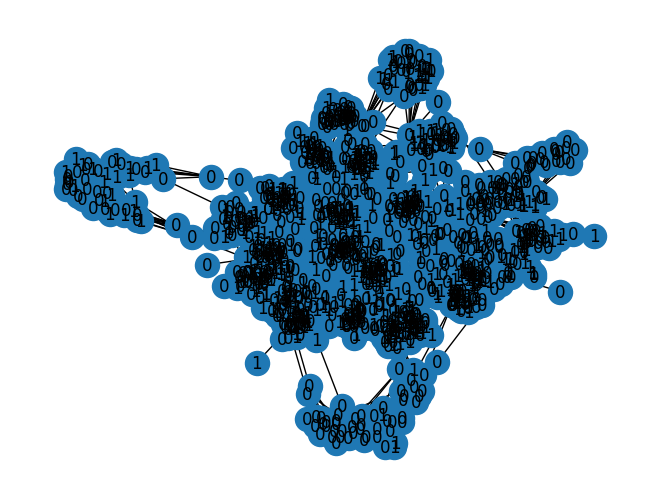

In [6]:
AdvancedGraphCreator.draw_graph_with_label(GS[i])

# Generation test data

Qui come prima generiamo allo stesso modo un insieme di dati che saranno effettuati per effettuare il testing del modello per valutarne le prestazioni.\
Per questo fine realizziamo delle reti più compatte.

In [7]:
gc = AdvancedGraphCreator(max_nodes=650,drop_prob=0.65)
GS = []
k = 30
rounds = 15
for i in range(k):
    beta = rand.uniform(0.01,0.1)
    ratio = rand.uniform(0.65,0.80)
    rate = rand.uniform(0.05,0.15)
    fraction_mis = rand.uniform(0.01,0.05)
    g = gc.generate_net(rounds,ratio=ratio,beta=beta,rate=rate,fraction_mis=fraction_mis)
    if g!=None:
        GS.append(g)
write_to_json(GS,path='advanced mixed test.json')

Mostriamo un esempio di rete generata.

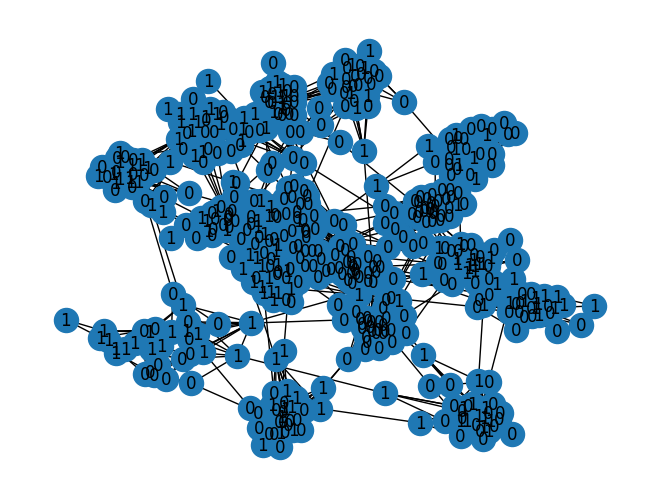

In [8]:
AdvancedGraphCreator.draw_graph_with_label(GS[1])